In [1]:
# the necessary import statements!

# to paralelize and accelerate the calculations
import numba as nb
from numba import jit
from numba import njit


import joblib
from joblib import Parallel, delayed
import multiprocessing


# numpy for fast calculations using arrays
import numpy as np

# scipy for minimization
import scipy
from scipy import optimize
from scipy.optimize import minimize as spmin
from scipy.optimize import Bounds

# some trigonometric functions
from math import pi, sin, cos, sqrt
import math

# to plot graphics
import matplotlib.pyplot as plt
%matplotlib inline

# the time of some calculations
import timeit

import dlib

import random

from tqdm import tnrange, tqdm_notebook

In [2]:
#import pandas_profiling

In [3]:
# parameters of the simulation

Msat=float(1000/(4*pi))
Ms=float(1/Msat)

#K1=float(((1*1.00)*10**4))
K1=float(((-0*6.00)*10**4))
K2=float((-0*0.05*10**5))
Kuni=float((0*0.6*10**4))
Kuni2=float((0*0.5*10**4))
K1mel=float((0*0.5*10**4))
K1out=float((0*2.0*10**4))
Knucl=float((0*1.0*10**4))

# EB parameters!
#Kf1=float(((1*4.000)*10**2))
Kf1=float(((-0*1.000)*10**3))
Kf1_bi=float(((1*10.000)*10**3))
Kf2_bi=float(((-1*5.000)*10**3))
#Kf1_gal=float(((1*3.000)*10**3))
Kf1_gal=float(((-1*3.500)*10**3))
Kf2_gal=float(((1*1.000)*10**3))
Krot_gal=float(((0*1.5000)*10**3))
Kf1_bi_gal=float(((1*5.000)*10**3))

gal_deg = 40*pi/180

tf=10.*10**-9
Jeff_EB=float(((0*0.0010/tf)*10**-3))/(Msat**2)
#Jeff_EB=float(((0*0.000010/tf)*10**-3))/(Msat**2)
Jeff_C=float(((0*0.003/tf)*10**-3))/(Msat**2)
Jeff_C_quad=float(((0*0.0005/tf)*10**-3))/(Msat**2)

gamma_f = 0*3.1415/4.-6*pi/180.
phi_eb = 1*3.1415/180.
theta_eb = 3.1415/2.+1*pi/180.
thetarma = 3.1415/2.+1*pi/180.
tau_avg = 300*10**-6
tempo = 1*500*tau_avg

Neff=float(1.00*1.000)
#field-dependent anisotropy
Kfd=float(-0*0.30*10**0)
#Krot=float((1*2.50*10**4))
Krot=float((-0*1.65*10**4))
Krot2=float((-0*1.80*10**3))
htheta=float(+2*pi/4.+1.00*pi/180.)
hphi=float(0*pi/4+5.00*pi/180.)

# Nanoparticle arrangement order
# 1-> square
# 2-> ring
# 3-> nanomembrane
np_order = 1


Nparticles=30

height=1

NN=Nparticles**3
NN2=Nparticles**2

#NN2=2

# interaction strengths!

m = -0*0.8

beta = 0*0.03

jota = -0*0.004

jotabi = -0*0.04

# campo termico

field_temp = 2*0.0000008
field_temp = 4*0.0000008



In [4]:
# applied field parameters

hini=200.400*1
hfinal=-200.400*1
step=400*4
stepmag=0.15/step
stepmag=0.00/step
hpasso=(hfinal-hini)/step
print(K1,K2,Krot,Msat,step)

0.0 0.0 0.0 79.57747154594767 1600


In [5]:
Jeff_EB/(Kf1/Msat**2),Jeff_C/(Kf1/Msat**2),Jeff_C_quad/(Kf1/Msat**2),beta/(Kf1_gal/Msat**2)

ZeroDivisionError: float division by zero

In [6]:
beta/(Kf1_gal/Msat**2)

-0.0

In [7]:
m/(Kf1_bi/Msat**2)

0.0

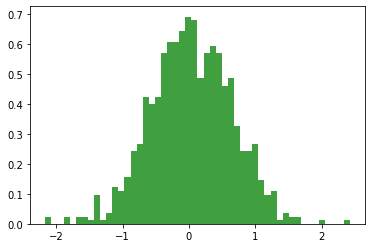

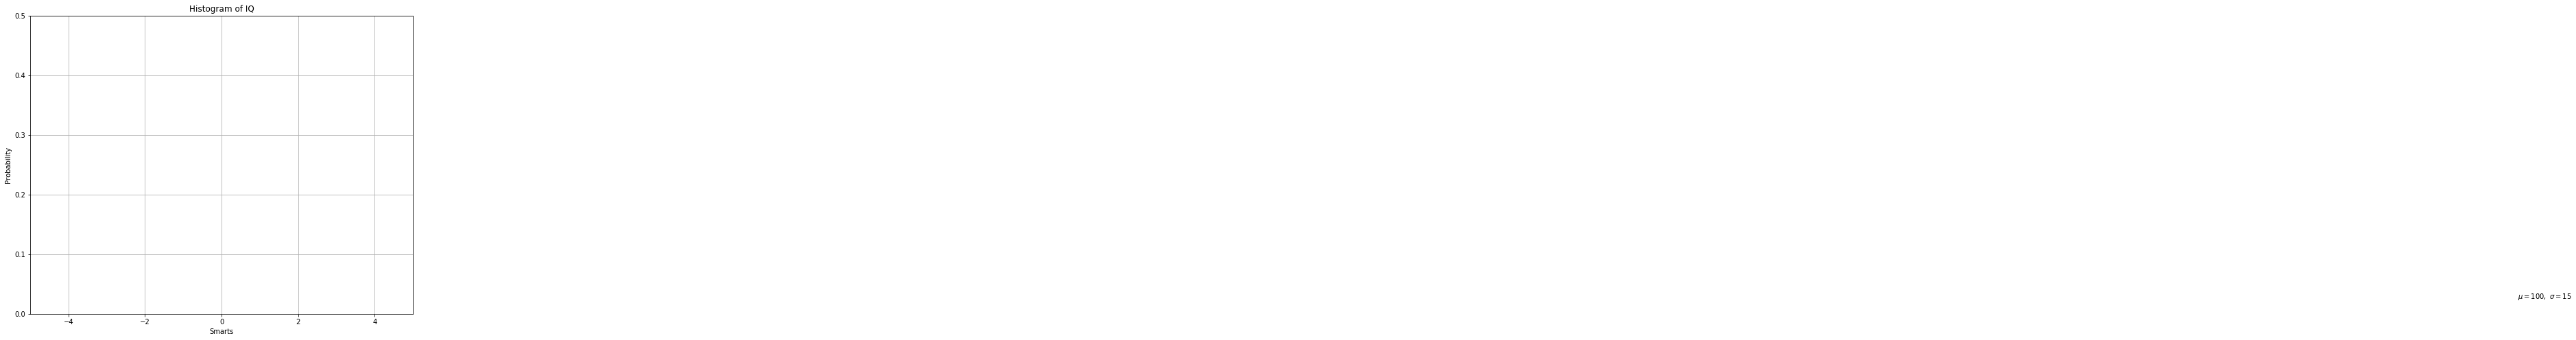

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 0, 0.6
x = mu + sigma * np.random.randn(NN2)

# the histogram of the data
n, bins, patches = plt.hist(x, 50, density=True, facecolor='g', alpha=0.75)


plt.figure(figsize=[10,8])
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(-5, 5)
plt.ylim(0, 0.5)
plt.grid(True)
plt.show()

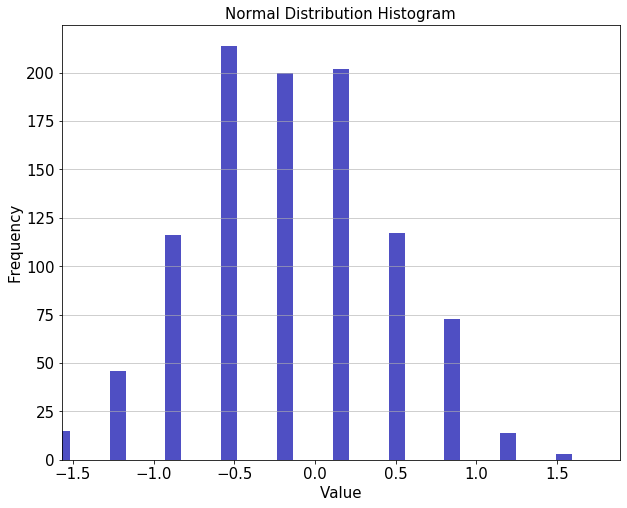

In [9]:
NN2
rand_gauss=np.random.normal(0,0.6,1000)
hist,bin_edges = np.histogram(rand_gauss)
#print(rand_gauss)
import matplotlib.pyplot as plt
plt.figure(figsize=[10,8])

plt.bar(bin_edges[:-1], hist, width = 0.1, color='#0504aa',alpha=0.7)
plt.xlim(min(bin_edges), max(bin_edges))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.title('Normal Distribution Histogram',fontsize=15)
plt.show()

In [10]:
bin_edges

array([-1.56782513, -1.22222437, -0.87662362, -0.53102286, -0.1854221 ,
        0.16017866,  0.50577941,  0.85138017,  1.19698093,  1.54258168,
        1.88818244])

In [11]:
# array for angle dispersion in 'phi' and 'theta'

phi_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
theta_np = np.array([0*random.random() for x in range(NN2)],dtype=np.float64)
#print(phi_np)

In [12]:
# the function that defines the common magnetic anisotropy terms
#@jit(nopython=True)
@jit(nopython=True,parallel=True)
#def anisotropy(phi,theta,K1,K2,h,htheta,hphi,Msat,i):
def anisotropy(phi,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

    phiant=phiantarray[i]
    thetaant=thetaantarray[i]

#    anis+=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-3.1415/4.)**2
#    anis=Kuni/(Msat**2)*np.sin(phi-3.1415/4.)**2*np.sin(theta-0.94)**2

#    anis=Kuni/(Msat**2)*np.cos(phi-3.1415/4.)**2*np.sin(phi-3.1415/4.)**2*np.sin(theta)**2
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)
#    anis=Kuni/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4)
    
#    theta=theta+0.97
#    phi=phi-3.1415/4.

    
# first-order cubic magnetocrystalline anisotropy
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**4+np.sin(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2+np.cos(phi-3.14/4.)**2*np.sin(theta-0.94)**2*np.cos(theta-0.94)**2)
#    anis=K1/(Msat**2)*(np.sin(phi-3.14/4.)**2*np.cos(phi-3.14/4.)**2*np.sin(theta)**4+np.sin(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2+np.cos(phi-3.14/4.)**2*np.sin(theta)**2*np.cos(theta)**2)
#    anis+=K1/(Msat**2)*(np.sin(phi-phi_np[i])**2*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**4+np.sin(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2+np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2*np.cos(theta-theta_np[i])**2)

# second-order cubic magnetocrystalline anisotropy    
#    anis+=K2/(Msat**2)*np.sin(phi)**2*np.sin(theta)**2*np.cos(phi)**2*np.sin(theta)**2*np.cos(theta)**2

# Eb anisotropy terms!

    anis= (Kf1/(Msat**2))*(np.sin(phi-gamma_f)**2)
    
    anis+= Kf1_bi/(Msat**2)*np.sin(phi-gamma_f)**2*np.cos(phi-gamma_f)**2
    anis+= Kf1_bi_gal/(Msat**2)*np.sin(phi-pi/4.)**2*np.cos(phi-pi/4.)**2
#    anis+= Kf2_bi/(Msat**2)*np.sin(phi-gamma_f)**4*np.cos(phi-gamma_f)**4

    anis+= Kf1_gal/(Msat**2)*np.cos(phi-gal_deg)**2
    anis+= Kf2_gal/(Msat**2)*np.cos(phi-gal_deg)**4
    anis+=Krot_gal/(Msat**2)*(np.cos(phi-hphi))**2    
    # demagnetizing energy
#    anis+=2*3.1415*Neff/(Msat**2)*np.cos(theta)**2

#    anis+=Knucl/(Msat**2)*np.sin(theta-thetaant)*np.cos(phi-phiant)**1
    
#    anis+=K1out/(Msat**2)*np.cos(theta)**2

    
    # magelas anisotropy 
    
#    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
#    anis+=K1mel/(Msat**2)*np.cos(theta)**2
#    anis+=K1mel/(Msat**2)*np.cos(phi-phi_np[i])**2*np.sin(theta-theta_np[i])**2
    
    
# uniaxial anisotropy 
    
    
# uniaxial anisotropy 
    
#    anis+=Kuni2/(Msat**2)*np.sin(phi-3.1415/4.)**4*np.sin(theta-0.94)**4

# field dependent anis!

#    anis+=Kfd/(Msat**2)*h*Msat*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))
#    anis+=Kfd/(Msat**2)*h*Msat**2*(np.sin(theta)*np.cos(phi-3.1415/4.))**2
    
# rotatable anis!

#    anis+=Krot/(Msat**2)*(h*Msat)**1*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**1
#    anis+=Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta-theta_np[i])*np.cos(phi-phi_np[i]-hphi)+np.cos(htheta)*np.cos(theta-theta_np[i]))**2
    

    """
    if(abs(h*Msat)>100):
    
        anis+=0*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    else:
        anis+=(100-abs(h*Msat))/100.*Krot/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**2
    """
    
#    anis+=Krot2/(Msat**2)*(np.sin(htheta)*np.sin(theta)*np.cos(phi-hphi)+np.cos(htheta)*np.cos(theta))**4
    
#    print(Kf1_bi/(Msat**2),anis,gamma_f)
    
    return anis
    

In [13]:
import random

phiantarray=np.array([random.random() for x in range(NN2*height)],dtype=np.float64)
thetaantarray=np.array([random.random() for x in range(NN2*height)])


In [14]:
h=-1.
anisotropy(3.1415/4.,K1,K2,h,htheta,hphi,Msat,0,phiantarray,thetaantarray)

ValueError: No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special'

In [ ]:
np.random.normal(0,0.6)

In [15]:
# Zeeman Energy

#@jit(nopython=True)
@jit(nopython=True,parallel=True)
def zeeman_energy(phi,K1,K2,h,htheta,hphi,Msat,i):
    
    h=h+field_temp*np.random.normal(0,0.6)
    zeeman=-h*(np.cos(phi-hphi))


    return zeeman


In [16]:
# creating positions!
# this is for creating positions!

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
def create_pos(np_order,NN2):
    
    if(np_order==1):
        
        nnx=int(sqrt(NN2))
        nny=int(sqrt(NN2))
        
        coord_pos = []
#        coord_pos = np.zeros((nnx,nny,nnx))
#        coord_pos = np.zeros(NN2)
        
        for i in range(nnx):

            for j in range(nnx):
                
#                coord_pos.append([i,j,0])
                coord_pos.append([1*i,1*j,0])
#                coord_pos = np.append(coord_pos,[1*i,1*j,0])

#                coord_pos[i][j][0] = np.array([1*i,1*j,0])
    
    elif(np_order==2):
        
        coord_pos=[]
        
        for i in range(NN2):
            
            coord_pos.append([NN2*math.cos(2*pi*i/NN2),NN2*math.sin(2*pi*i/NN2),0])
    
    elif(np_order==3):
        
        coord_pos=[]
        
        for j in range(height):
        
            for i in range(NN2):

                coord_pos.append([NN2*math.cos(2*pi*i/NN2),j,NN2*math.sin(2*pi*i/NN2)])

    return np.array(coord_pos,dtype=np.float64)


In [17]:
# this is to create the angles, which are used in the computation of the interactions!

ar_pos=create_pos(np_order,NN2)


#@jit(nopython=True,parallel=True)
@jit(nopython=True)
def angles_vecs(NN2):

    print(np_order)
#    ar_pos=create_pos(np_order,NN2)

#    print(ar_pos)
    
    x_coord = [ar_pos[i][0] for i in range(NN2*height)]
    y_coord = [ar_pos[i][1] for i in range(NN2*height)]
    z_coord = [ar_pos[i][2] for i in range(NN2*height)]

    x_ang = []
    y_ang = []
    
    for i in range(NN2*height):
        x_ang_menor=[]
        y_ang_menor=[]
        
        for j in range(NN2*height):
            
            if(i!=j):
                innerproduct = x_coord[i]*x_coord[j]+y_coord[i]*y_coord[j]

                dist1 = sqrt(x_coord[i]**2+y_coord[i]**2+z_coord[i]**2)
                dist2 = sqrt(x_coord[j]**2+y_coord[j]**2+z_coord[j]**2)
                
                distnewvec = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2+(z_coord[j]-z_coord[i])**2)
                distnewvecplane = sqrt((x_coord[j]-x_coord[i])**2+(y_coord[j]-y_coord[i])**2)
                
                if(distnewvecplane!=0.0):
#                    angphi = math.acos((x_coord[j]-x_coord[i])/distnewvecplane)
#                    angtheta = math.acos((z_coord[j]-z_coord[i])/distnewvec)
                    angphi = math.acos((x_coord[i]-x_coord[j])/distnewvecplane)
                    angtheta = math.acos((z_coord[i]-z_coord[j])/distnewvec)
                elif(distnewvecplane == 0.0):
                    angphi = 0.0
                    angtheta = 3.1415/2.
                x_ang_menor.append(angphi)
                y_ang_menor.append(angtheta)
                
            elif(i==j):
                
                x_ang_menor.append(0.0)
                y_ang_menor.append(0.0)
                
        x_ang.append(x_ang_menor)
        y_ang.append(y_ang_menor)
        x_ang_menor=[]
        y_ang_menor=[]
                

                
#    return np.array(x_ang,dtype=np.float64),np.array(y_ang,np.float64)
#    return np.array(x_ang),np.array(y_ang)
    return x_ang,y_ang

In [18]:
# Function to calculate the distance between particles 'i' and 'j'

#@jit(nopython=True)
def dist_dipolar(i,j):
    sizex=int(sqrt(NN2))
    sizey=int(sqrt(NN2))
    
    # distance of particle 'j' from particle 'i'
#    distdip=[]
    '''
    for ii in range(sizex):
        for jj in range(sizey):
            distdip.append(sqrt((int(i/sizex)-ii)**2+(int(i%sizey)-jj)**2))
    '''
    
    '''
    distdip=sqrt((int(i/sizex)-int(j/sizex))**2+(int(i%sizey)-int(j%sizey))**2)
    '''

    if(np_order==1):

        distdip=[]
        for ii in range(NN2):
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((int(ii/sizex)-int(jj/sizex))**2+(int(ii%sizey)-int(jj%sizey))**2))
            distdip.append(distdip1)
            
    elif(np_order==2):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2):
            distmin=[]
            distdip1=[]
            for jj in range(NN2):
                distdip1.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))
            
                if(ii!=jj):
                    distmin.append(sqrt((math.cos(2*pi*ii/NN2)-math.cos(2*pi*jj/NN2))**2+(math.sin(2*pi*ii/NN2)-math.sin(2*pi*jj/NN2))**2))

            arraydistmin=np.array(distmin)
            
            distdip1new=[]
            
            for u in range(NN2):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))
            
            distdip.append(distdip1new)
#            distdip1=np.array(distdip1)
#            distmin=np.array(distmin)
#            distdip[ii]=distdip1/np.amin(distmin)
#            distdip=np.array(distdip)


    elif(np_order==3):
        
        distdip=[]
#        distdip=np.empty(NN2)
        for ii in range(NN2*height):
            distmin=[]
            distdip1=[]
            for jj in range(NN2*height):
#                for kkk in range(height):
#                    for kk in range(height):
           
                distdip1.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

                if(ii!=jj):
                
                    distmin.append(sqrt((math.cos(2*pi*(ii%NN2)/NN2)-math.cos(2*pi*(jj%NN2)/NN2))**2+(math.sin(2*pi*(ii%NN2)/NN2)-math.sin(2*pi*(jj%NN2)/NN2))**2+((int(ii/NN2)-int(jj/NN2))/height)**2))

            arraydistmin=np.array(distmin)

            distdip1new=[]
            if(np.amin(arraydistmin)==0.0):
                print(ii,'ii')
                print(distdip1[1])
                print('zerou',np.argmin(arraydistmin),arraydistmin[np.argmin(arraydistmin)-1])
                break

            for u in range(NN2*height):
                distdip1new.append(distdip1[u]/np.amin(arraydistmin))

            distdip.append(distdip1new)



#        distdip=[]
        
#    return np.array(distdip,dtype=np.float64)
#    return distdip[j]
    return distdip


In [19]:
ii=20
jj=30
print(len(dist_dipolar(2,3)))
#dist_dipolar(20,30)[14][25]




900


In [20]:
vec_dip=np.array(dist_dipolar(20,30))

In [21]:
x_ang,y_ang = angles_vecs(NN2)
#rr=dist_dipolar(i)
x_ang=np.array(x_ang,dtype=np.float64)
y_ang=np.array(y_ang,dtype=np.float64)

1


In [22]:
len(x_ang[1])


900

In [23]:
y_ang[1]

array([1.57079633, 0.        , 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633,
       1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079

In [24]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = pi/2.
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')
    theta=pi/2.
    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
    inter_dipolar=-3*beta/(rr**3)*(np.sin(theta)*np.sin(y_ang[i][j])*np.cos(phi-x_ang[i][j])+np.cos(theta)*np.cos(y_ang[i][j]))*(np.sin(thetaant)*np.sin(y_ang[i][j])*np.cos(phiant-x_ang[i][j])+np.cos(thetaant)*np.cos(y_ang[i][j]));
    inter_dipolar+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(inter_dipolar,'dipolar')
    
    return inter_dipolar
    
# exchange energy

# moriya energy



In [25]:
energy_interdipolar(0.2,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,0,1)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-24-7c335a5f0921>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [26]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = pi/2.
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]
    theta=pi/2.
#    create_pos(np_order,NN2)
    inter_exc=jota*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [27]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_eb(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = pi/2.
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]
    theta=pi/2.
#    create_pos(np_order,NN2)
    inter_exc= -Jeff_EB*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(theta_eb)*np.cos(phi-phi_eb)+np.cos(theta)*np.cos(theta_eb))
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [28]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_rma(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = pi/2.
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)
#    theta_rma = theta*(tempo-tau_avg)
    thetarma = 3.1415/2.
    theta = 3.1415/2.
#    theta_rma = theta
#    phi_rma=phi*(tempo-tau_avg)
    arg=phi-phi*(tempo-tau_avg)
    inter_exc = -Jeff_C*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(arg))
    inter_exc += -Jeff_C_quad*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phi-phi*(tempo-tau_avg)))**2
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_exc


In [29]:
energy_interexchange_rma(pi/2.,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-28-08d8bd3128b4>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_rma(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [30]:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = pi/2.
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]
    theta=pi/2.
#    create_pos(np_order,NN2)
    inter_excbi=jotabi*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))**2
#    print(jota*np.exp(-rr)/np.exp(-1.0))
#    print((np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant)))

#    print(inter_dipolar,'dipolar')
    
    return inter_excbi


In [31]:
energy_interexchange_eb(0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-27-acd1e866836c>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange_eb(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [32]:
energy_interexchange(0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-26-d74b0f53a94e>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [33]:
energy_biinterexchange(0.0,phiantarray,thetaantarray,K1,K2,0.3,htheta,hphi,4,5)

/home/vagner/anaconda3/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-30-5915cb07102c>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_biinterexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  state.func_ir.loc))


0.0

In [34]:
# the interactions
#vec_dip_called = np.array(vec_dip)

#@jit(nopython=True)
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    #obtaining the angles to calculate the interactions!

#    print(i,'i before')
#    print(j,'j before')
    
#    x_ang,y_ang = angles_vecs(NN2)
#    print(i,'i')
#    print(j,'j')
#    print(phiantarray)
    phiant = phiantarray[j]
    thetaant = thetaantarray[j]
# dipolar energy

#    phiant=phi+phiantarray[j]-phiantarray[i]
#    thetaant=theta+thetaantarray[j]-thetaantarray[i]

#    print(beta,'beta')

    rr=vec_dip[i][j]
#    rr=vec_dip_called[i][j]

#    create_pos(np_order,NN2)

#   vectorial product with k^ versor !
    thetaant=pi/2.
    theta=pi/2.
    

    if(i<=j):
        if(j==i+1):
            ## produto vetorial z^ vec x^ = y^!
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
            ## produto vetorial z^ vec y^ = - x^!
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=+m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
        
    elif(i>=j):
        if(j==i-1):
#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));

#            inter_moriya=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
        
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
        
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
            
        else:
#            inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));

#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));
#            inter_moriya+=-m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta));
            
            # biquadratic
            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))**2;
            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(thetaant)*np.cos(phiant)*np.sin(theta)*np.sin(phi)-np.sin(theta)*np.cos(phi)*np.sin(thetaant)*np.sin(phiant))**2;
            
            # chiral multi spin
#            inter_moriya=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(phiant)*np.cos(theta)*np.sin(thetaant)-np.cos(phi)*np.cos(thetaant)*np.sin(theta))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));
#            inter_moriya+=m/2.*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant))*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant));

#            inter_moriya=-m*np.exp(-rr**9)/np.exp(-1.0)*(np.cos(thetaant)*np.sin(phi)*np.sin(theta)-np.cos(theta)*np.sin(phiant)*np.sin(thetaant));


#    inter_moriya=m*np.exp(-rr**3)/np.exp(-1.0)*(np.cos(phi)*np.sin(phiant)*np.sin(theta)*np.sin(thetaant)-np.cos(phiant)*np.sin(phi)*np.sin(theta)*np.sin(thetaant));
#    inter_moriya=m*np.exp(-rr**9)/np.exp(-1.0)*(np.sin(theta)*np.sin(thetaant)*np.sin(phi-phiant));

    

    
#    inter_moriya+=beta/(rr**3)*(np.sin(theta)*np.sin(thetaant)*np.cos(phi-phiant)+np.cos(theta)*np.cos(thetaant))

#    print(m,'dipolar')
    
    return inter_moriya
    
# exchange energy

# moriya energy



In [35]:
# energy array

#@jit(nopython=True,parallel=True)
#@jit(nopython=True)
#@njit(fastmath=True,parallel=True)
@njit(fastmath=True)
def energy_array_inter(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):

    '''
    
    listaNN1=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN1[x] = int(sqrt(NN2))-x-2
                                
    listaNN2=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN2[x] = int(sqrt(NN2))*(x+2)-1
                                
    listaNN3=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN3[x] = NN2-x-2
    
    listaNN4=[0. for x in range(int(sqrt(NN2))-2)]
    
    for x in range(0,int(sqrt(NN2))-2):
        listaNN4[x] = int(sqrt(NN2))*(x+1)

#    print('listas',listaNN1,listaNN2,listaNN3,listaNN4)

    """
    for x in range(NN2):
        
        x=i
        for y in range(int(sqrt(NN2))-2):
            
            print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
            if(listaNN1[y]==x):
                                
                foi=-1
                                
            elif(listaNN2[y]==x):
                                
                foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN3[y]==x):
                                
                foi=-3
#                print(foi,'foi dentro',listaNN3[y],x)
                                
            elif(listaNN4[y]==x):
                                
                foi=-4
            else:
                                
                foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    """                         

    
        
    x=i
    for y in range(int(sqrt(NN2))-2):
            
#        print(listaNN3[y]==x)
#            print(x,y,'xy')
                                
        if(listaNN1[y]==x):
                                
            foi=-1
            break
                                
        elif(listaNN2[y]==x):
                                
            foi=-2
#                print(foi,'foi dentro',listaNN3[y],x)
            break
                                
        elif(listaNN3[y]==x):
                                
            foi=-3
            break
#                print(foi,'foi dentro',listaNN3[y],x)
                                
        elif(listaNN4[y]==x):
                                
            foi=-4
            break
        else:
                                
            foi=-5
#            print(foi,'foi dentro',listaNN3[y],x)
    
    
    
#    print(foi,'foi fora')
                                
#    print(i,j)
    
    # defining the energy array!
    energy_vec=[0.0 for x in range(NN2)]
    
    
    if(np_order==1):
        
        if(i==0):
        
            dip_b=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2)))
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,int(sqrt(NN2))-1)
            dip_b+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,0,NN2-int(sqrt(NN2)))
            
            
            energy_vec[i]=dip_b

    
        elif(foi==-1):
                
                
#            print(i,'i dentro de foi=-1')
            
            dip_f=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_f+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,NN2-int(sqrt(NN2))+i)
            
#            print(dip_f,'dip_f')
    
            energy_vec[i]=dip_f

        elif(i==int(sqrt(NN2)-1)):
                                
            dip_c=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,int(sqrt(NN2))-2)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,2*int(sqrt(NN2))-1)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,0)
            dip_c+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,int(sqrt(NN2))-1,NN2-1)

            energy_vec[i]=dip_c

        elif(foi==-2):

            
            dip_q=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_q+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2))+1)
            
            energy_vec[i]=dip_q

        elif(i==NN2-1):
                                
            dip_e=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))-2)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,NN2-1-int(sqrt(NN2))+1)
            dip_e+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-1,int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_e

        elif(i==NN2-int(sqrt(NN2))):
                                
            dip_d=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-int(sqrt(NN2))+1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-2*int(sqrt(NN2)))
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),NN2-1)
            dip_d+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,NN2-int(sqrt(NN2)),0)
                                
            energy_vec[i]=dip_d
                                
        elif(foi==-3):
                                
            dip_g=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_g+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-i%(int(sqrt(NN2))))
            
            energy_vec[i]=dip_g
                                
        elif(foi==-4):
            
            
#            print('aqui o erro!')
            
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
            dip_p+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_p=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2))-1)
                                
            energy_vec[i]=dip_p
                                
        else:
            
#            print('aqui o erro!')
            
                                
            dip_a=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-1)
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i-int(sqrt(NN2)))
            dip_a+=energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,i+int(sqrt(NN2)))
                                
            energy_vec[i]=dip_a
    '''                         
    # defining the energy array!
#    energy_vec=[0.0 for x in range(NN2)]

    # summing up all the contributions    
#    '''
    if(np_order==1 or np_order==2):
        soma_dip = 0.0
        for j in nb.prange(NN2):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_biinterexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_moriya(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
#                soma_dip+= energy_interexchange_eb(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_eb(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_rma(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
    elif(np_order==3):
        soma_dip = 0.0
        for j in nb.prange(NN2*height):
#        for j in range(NN2*height):
            if(i!=j):
                soma_dip+= energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_biinterexchange(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_moriya(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_eb(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
                soma_dip+= energy_interexchange_rma(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
#                print(j,soma_dip)
#    '''
#    soma_dip = sum(energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2))
    '''

    soma_dip = []
    soma_dip=np.array([energy_interdipolar(phi,theta,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j) for j in range(NN2) if i!=j])
    soma_dip=np.sum(soma_dip)
    '''
    
#    energy_vec[i]=soma_dip
                                
                                
#    return energy_vec
#    return np.array(energy_vec)
    return soma_dip
                                
                                
                                
                                
                                
                                
                                
                                

In [36]:
energy_array_inter(1,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,1,0)


<ipython-input-35-6189ccb45444>:215: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-24-7c335a5f0921>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  soma_dip+= energy_interdipolar(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j)
<ipython-input-35-6189ccb45444>:216: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-26-d74b0f53a94e>", line 2:
@jit(nopython=True,parallel=True,fastmath=True)
def ene

0.0

In [37]:
#@jit(nopython=True,parallel=True)
@jit(nopython=True,fastmath=True)
def free_energy(xx,K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray):

#    anis = anisotropy(xx[0],xx[1],K1,K2,h,htheta,hphi,Msat,i)
    anis = anisotropy(xx[0],K1,K2,h,htheta,hphi,Msat,i,phiantarray,thetaantarray)

    zeeman = zeeman_energy(xx[0],K1,K2,h,htheta,hphi,Msat,i)

    inter = energy_array_inter(xx[0],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,0)
#    inter = energy_array_inter(xx[0],xx[1],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,3,0)
    
    expr_calc = anis + zeeman + inter
    
#    return np.array(expr_calc,dtype=np.float64)
    return expr_calc
    
    

In [38]:
#testing!
h=-5.01
ii=0
x0=np.array([0],dtype=np.float64)
a=free_energy(np.array([0.],dtype=np.float64),K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray)
print(a)
minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,ii,phiantarray,thetaantarray),bounds=[[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
print(minxy)


4.935437677029519
      fun: -4.881514435288581
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-268.09758014])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 4
   status: 0
  success: True
        x: array([-3.30214187])


<ipython-input-37-4990a6801433>:10: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-34-7699bb48248e>", line 6:
@jit(nopython=True,parallel=True,fastmath=True)
def energy_moriya(phi,phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,j):
^

  inter = energy_array_inter(xx[0],phiantarray,thetaantarray,K1,K2,h,htheta,hphi,i,0)
<ipython-input-37-4990a6801433>:6: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-12-26eaf7f25752>", line 4:
@jit(nopython=True,parallel=True)
#def anisotropy(phi,theta,K1,K2,

In [39]:
# the main program, where minimization of overall energy is performed!



#@jit(nopython=True)
#@jit(fastmath=True)
#@vectorize
#@stencil
def hysteresis_inter(NN2,Msat,hpasso,hphi):
    
    
    hnow=hini/Msat
    
#    hnowlist=np.array([])
#    maglist=np.array([])
#    maglistend=np.array([])


    hnowlist=np.empty(step+1)
    maglist=np.zeros(NN2*height+1)
    maglistend=np.array([])


    Msat0=Msat
#    for particle in range(NN2):
#    for i in range(1,int(step+1)):

    Msat=Msat0
#    maglistend0=np.array([[]])
    maglistend0 = np.empty(step, dtype=object)
#    maglistend0 = np.zeros(step, dtype=np.float64)
    
    hnow=hini/Msat
    htest=np.array([])
    hlist=np.array([])


#    for i in range(1,step+1):

#    print(hphi,Kf,Kf_bi)
    for i in range(1,step+1):
#    for i in tnrange(step+1,desc='Calculation Progress'):

        if(i==0):
            continue
        
        if(hnow>=0):
            coefmag=(1+(step/2-i)*2*stepmag)
#            coefmag=(1-(step/2-i)*stepmag)
        else:
            coefmag=(1+(i-step/2)*2*stepmag)
#            coefmag=(1-(i-step/2)*stepmag)
        
#        phiantarraynew=np.array([])
#        thetaantarraynew=np.array([])
        phiantarraynew=np.empty(NN2*height)
        thetaantarraynew=np.empty(NN2*height)
        
#        for i in range(1,int(step+1)):
        for particle in range(NN2*height):
            
#            print(particle,'particle')
            
                
#            print(coefmag,'coefmag')
#            print(i,'i loop')
            if(i==1):
            
                angx=hphi#+np.pi
                angy=htheta#+np.pi
                
                phiantarray_vai=np.array([hphi for x in range(NN2*height)],dtype=np.float64)
                thetaantarray_vai=np.array([htheta for x in range(NN2*height)],dtype=np.float64)
#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
                
#                print(phiantarray_vai)

                h=hnow
                    
                Msat=Msat0*coefmag
                
                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                x0=np.array([angx],dtype=np.float64)
                
#                print(x0,'x0')
#                minxy=spmin(free_energy,[x0],args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-100*3.1415,100*3.1415],[-100*3.1415,100*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
#                print('chegaaqui')
            
                angx=minxy.x[0]
#                angy=minxy.x[1]
                #print(angx,'angx')
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
#                thetaantarraynew[particle] = angy
                thetaantarraynew[particle] = htheta

        
        
        
        
#                print(phiantarraynew,np.array([angx]))
#                dfsol=minxy.x[2]
#                print(phiantarraynew)
#                hlist.append(hnow*Msat)
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.cos(angx-hphi)))

                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
#                    print(phiantarraynew)
                    
#                phiantarraynew=[]
#                thetaantarraynew=[]
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#            hnowlist=np.append(hnowlist,hnow*Msat)

            
#            print(i,'ii')    
#            print(phiantarraynew2,'phiant2')
#            print(maglist,'maglist')

#            phiantarraynew=[]
#            thetaantarraynew=[]
            
            
            if(i!=1):
                
                if(particle==0):
                    phiantarray_vai=np.copy(phiantarraynew2)
                    thetaantarray_vai=np.copy(thetaantarraynew2)
#                print(phiantarray_vai)

#                phiantarray=np.array(phiantarray)
#                thetaantarray=np.array(thetaantarray)
#                print(phiantarray,'secondphiantarray')

                angx=phiantarray_vai[particle]
                angy=thetaantarray_vai[particle]
                
                Msat=Msat0*coefmag
                #            x0=np.array([angx,angy,dfsol],dtype="float")
                x0=np.array([angx],dtype=np.float64)
                h=hnow
                
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-10000*3.1415,10000*3.1415],[-10000*3.1415,10000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=spmin(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415],[-1000*3.1415,2000*3.1415]],tol=1e-100,options={'ftol': 1e-30})
#                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),method='nelder-mead',tol=1e-400,options={'ftol': 1e-300})
                minxy=scipy.optimize.minimize(free_energy,x0,args=(K1,K2,h,htheta,hphi,Msat,particle,phiantarray_vai,thetaantarray_vai),bounds=[[-2000*3.1415,4000*3.1415]],tol=1e-400,options={'ftol': 1e-300})
                
                angx=minxy.x[0]
#                angy=minxy.x[1]

                
                
#                phiantarraynew.append(angx)
#                thetaantarraynew.append(angy)
#                phiantarraynew=np.append(phiantarraynew,angx)
#                thetaantarraynew=np.append(thetaantarraynew,angy)
                phiantarraynew[particle] = angx
#                thetaantarraynew[particle] = angy
                thetaantarraynew[particle] = htheta
        
#                maglist.append(coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))

#                maglist=np.append(maglist,coefmag*((np.sin(htheta)*np.sin(angy)*np.cos(angx-hphi)+np.cos(htheta)*np.cos(angy))))
                maglist[particle] = coefmag*((np.cos(angx-hphi)))
            
#                hlist.append(hnow*Msat)
#                phiantarraynew3=np.copy(phiantarraynew)
#                thetaantarraynew3=np.copy(thetaantarraynew)
#                phiantarraynew=[]
#                thetaantarraynew=[]

#                htest.append(minxy)
#                htest=np.append(htest,minxy)

                
                if(particle==NN2*height-1):
                    phiantarraynew2=np.copy(phiantarraynew)
                    thetaantarraynew2=np.copy(thetaantarraynew)
                    phiantarraynew=[]
                    thetaantarraynew=[]
#                    print(thetaantarraynew2)
#            hnow=hnow+hpasso/Msat

#            hnowlist.append(hnow*Msat)
#        hnowlist=np.append(hnowlist,hnow*Msat)
        hnowlist[i] = hnow*Msat
            
            #phiantarraynew=[]
            #thetaantarraynew=[]

#        hlist.append(hnow*Msat)
        hlist=np.append(hlist,hnow*Msat)
        if(i==int(step/2)):
            hpasso=-hpasso
            
            
        hnow=hnow+2*hpasso/Msat            
#        hnow=hnow+1*hpasso/Msat            
#        if(hnow>0.):
#            break

#        maglistend0.append(np.array(maglist)) 
#        maglist=[]
#        print(maglist,'maglist')
        if(i==1):
#            maglistend0=np.array([maglist])
            maglistend0[i-1] = maglist
        else:
#            maglistend0=np.concatenate((maglistend0,np.array([maglist])),axis=0)
            maglistend0[i-1] = maglist
#            print(len(maglist),'lenmag')
#        maglist=np.array([])
        maglist=np.zeros(NN2*height+1)
            
#    print(maglistend0)
#    print(len(maglistend0))
#    maglistend2=np.array([])
    maglistend2=np.empty(step)

    for j in range(len(maglistend0)):
        soma=0
        for i in range(len(maglistend0[0])):
            try:
                soma+=maglistend0[j][i]
            except:
                continue
#        maglistend2.append(soma/NN2)
#        maglistend2=np.append(maglistend2,soma/NN2)
#        print(soma/NN2,'soma')
        maglistend2[j]=soma/NN2/height
#        print(maglistend2[i],'aq')
#    maglistend.append(np.array(maglistend2)) 
#    maglistend=np.append(maglistend,maglistend2)
    maglistend=maglistend2

#    print(len(maglistend),'lastmagend')
#    hlist=[((hini+hpasso*x)) for x in range(step)]
#    print(len(htest),'htest')
    
    return maglistend,hlist,htest,hnowlist




In [40]:
Jeff_C/(Kf1/Msat**2)

ZeroDivisionError: float division by zero

In [ ]:
m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,0/1*pi/180.)

In [ ]:
m_inter

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(6,6))

plt.title("Interacting Single Domains",size=40)

#plt.scatter(np.array(h_inter)[:int(len(h_inter)*2/2.)],np.array(m_inter)[:int(len(h_inter)*2/2.)]/norm,color='r')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter))/1./norm,color='r')
#plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm,color='b')

#plt.scatter(hexp_on,np.array(mexp_on)/0.99)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

plt.show()



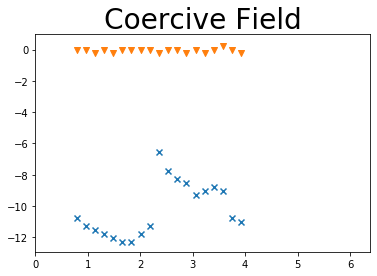

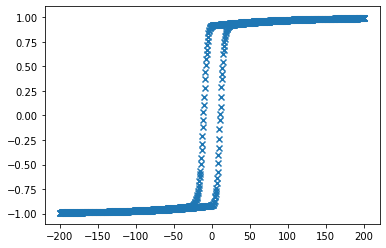


9955.904096364975


In [1145]:
import time
start=time.time()
from IPython.display import clear_output


#m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
divphi=1*18
phi_ini=1*pi/4.
phi_final=2/2.*pi+1*3.1415/4.
phi_step=(phi_final-phi_ini)/divphi
hphi=phi_ini+0.00*pi/180

list_hc=[]
list_eb=[]
for l in tnrange(divphi+1):
#for l in tnrange(5):
    m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,hphi)
    hc1,hc2=None,None
    for i in range(len(m_inter)):
#        if(m_inter[i]>0 and h_inter[i]>=0.0):
        if(m_inter[i]<0 and m_inter[i-1]>0):
            hc1=(h_inter[i-1]+h_inter[i])/2.
        if(m_inter[i]>0 and m_inter[i-1]<0):
            hc2=(h_inter[i-1]+h_inter[i])/2.
#            break
#    hc=h_inter[-1]
    hc=(hc1-hc2)/2.
    heb=(hc1+hc2)/2.
#    print(hphi,hc,heb)
    list_hc.append([hphi,hc])
    list_eb.append([hphi,heb])
    phi_ini+=phi_step
    hphi+=phi_step
    
    clear_output(wait=True)
    
    x_hc=[]
    y_hc=[]

    for i in range(len(list_hc)):
        x_hc.append(list_hc[i][0])
        y_hc.append(list_hc[i][1])    

    x_eb=[]
    y_eb=[]

    for i in range(len(list_eb)):
        x_eb.append(list_eb[i][0])
        y_eb.append(list_eb[i][1])    
    
#    plt.close()
    
    import matplotlib.pyplot as plt

    #plt.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
    plt.scatter(x_hc, np.array(y_hc), marker = 'x')
    plt.scatter(x_eb, np.array(y_eb), marker = 'v')
    plt.title("Coercive Field",size=28)
    #ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
    plt.xlim(-0/2*3.1415,4/2*3.1415+0.1)
    plt.show()
    
    plt.scatter(h_inter, m_inter, marker = 'x')
    plt.show()
    
list_hc=np.array(list_hc)
    
stop=time.time()
print(-start+stop)

In [1146]:
m_inter

array([0.99790408, 0.99672542, 0.99564364, ..., 0.98958327, 0.98964215,
       0.98968981])

In [1147]:
list_hc

array([[  0.78539816, -10.7715    ],
       [  0.9599298 , -11.2725    ],
       [  1.13446144, -11.523     ],
       [  1.30899308, -11.7735    ],
       [  1.48352472, -12.024     ],
       [  1.65805636, -12.2745    ],
       [  1.83258799, -12.2745    ],
       [  2.00711963, -11.7735    ],
       [  2.18165127, -11.2725    ],
       [  2.35618291,  -6.513     ],
       [  2.53071455,  -7.7655    ],
       [  2.70524619,  -8.2665    ],
       [  2.87977782,  -8.517     ],
       [  3.05430946,  -9.2685    ],
       [  3.2288411 ,  -9.018     ],
       [  3.40337274,  -8.7675    ],
       [  3.57790438,  -9.018     ],
       [  3.75243602, -10.7715    ],
       [  3.92696765, -11.022     ]])

In [1148]:
list_eb

[[0.7853981633974483, -8.881784197001252e-14],
 [0.9599298017414675, -8.79296635503124e-14],
 [1.1344614400854867, -0.25050000000008765],
 [1.3089930784295059, -8.79296635503124e-14],
 [1.483524716773525, -0.25050000000008854],
 [1.6580563551175442, -8.881784197001252e-14],
 [1.8325879934615634, -8.881784197001252e-14],
 [2.0071196318055824, -8.79296635503124e-14],
 [2.1816512701496014, -8.79296635503124e-14],
 [2.3561829084936203, -0.25050000000008854],
 [2.5307145468376393, -8.881784197001252e-14],
 [2.7052461851816583, -8.79296635503124e-14],
 [2.8797778235256772, -0.25050000000008854],
 [3.054309461869696, -8.79296635503124e-14],
 [3.228841100213715, -0.25050000000008854],
 [3.403372738557734, -8.881784197001252e-14],
 [3.577904376901753, 0.2504999999999118],
 [3.752436015245772, -8.881784197001252e-14],
 [3.926967653589791, -0.25050000000008854]]

In [1152]:
x_hc=[]
y_hc=[]

for i in range(len(list_hc)):
    x_hc.append(list_hc[i][0])
    y_hc.append(list_hc[i][1])    
    
x_eb=[]
y_eb=[]

for i in range(len(list_eb)):
    x_eb.append(list_eb[i][0])
    y_eb.append(list_eb[i][1])    
    
    

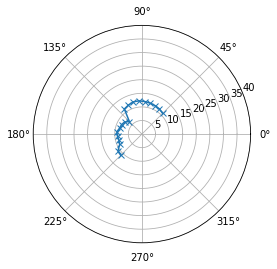

In [1153]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_hc, abs(np.array(y_hc)), marker = 'x')
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
ax.set_rmax(40)
ax.set_rmin(0)
plt.show()

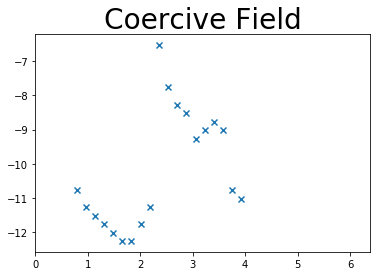

In [1154]:
import matplotlib.pyplot as plt

#plt.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
plt.scatter(x_hc, np.array(y_hc), marker = 'x')
plt.title("Coercive Field",size=28)
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
#plt.savefig("singledomain_temp.jpg")
plt.xlim(-0/2*3.1415,4/2*3.1415+0.1)
plt.show()

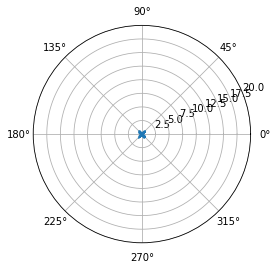

In [1155]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_eb, abs(np.array(y_eb)), marker = 'x')
ax.set_rmax(20)
ax.set_rmin(0)
plt.show()



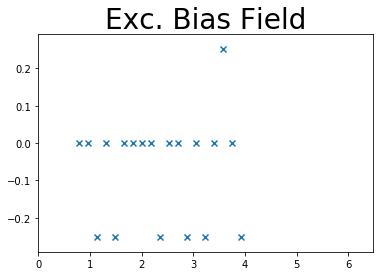

In [1156]:
import matplotlib.pyplot as plt

#plt.scatter(x_eb, abs(np.array(y_eb)), marker = 'x')
plt.scatter(x_eb, np.array(y_eb), marker = 'x')
#ax.scatter(x_hc, abs(np.array(y_hc)), marker = 'x')
plt.xlim(-0/2*3.1415,4/2*3.1415+0.2)
plt.title("Exc. Bias Field",size=28)
plt.show()

In [1157]:
# experimental data
path='/home/vagner/Desktop/galfenol/galhctheta.txt'
#path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

hc_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hc_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))

theta_on=np.array(hc_on)
hc_on=np.array(mexp_on)



0	33.3



In [1158]:
theta_on=theta_on*3.1415/180.

In [1159]:
theta_on

array([0.        , 0.17452778, 0.34905556, 0.52358333, 0.69811111,
       0.87263889, 1.04716667, 1.22169444, 1.39622222, 1.57075   ,
       1.74527778, 1.91980556, 2.09433333, 2.26886111, 2.44338889,
       2.61791667, 2.79244444, 2.96697222, 3.1415    ])

In [1160]:
hc_on

array([33.3 , 31.03, 31.29, 31.74, 28.  , 27.73, 32.33, 20.81, 20.81,
       22.66, 20.97, 20.18, 29.93, 27.63, 27.44, 29.77, 30.04, 33.57,
       37.03])

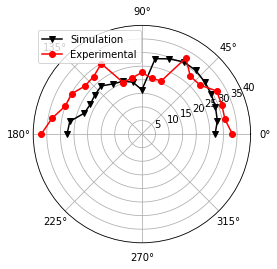

In [1163]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
l1=ax.plot(np.array(x_hc)-pi/4, 2.5*abs(np.array(y_hc)), marker = 'v',color='black',label='Simulation')
l2=ax.plot(theta_on, hc_on, marker = 'o',color='red',label='Experimental')

#l2=ax.plot(theta_on, mexp_on, marker = 'o',color='blue',label='Experimental')

ax.legend()
#plt.legend((l1,l2),('90 deg','50 deg'),fontsize=20)

ax.set_rmax(40)
ax.set_rmin(0)

# filme
#plt.savefig("polarplot_hc_cubic_moriyaquad.png")
#plt.savefig("polarplot_hc_cubic_dipolar.png")
#plt.savefig("polarplot_hc_cubic_exchange.png")
#plt.savefig("polarplot_hc_cubic_moriya.png")
#plt.savefig("polarplot_hc_cubic_moriyachiralmultispin.png")
#plt.savefig("polarplot_hc_cubic_exchangebiquad.png")

# nanomembrane!

#plt.savefig("polarplot_hc_cubic_moriyachiralmultispin_nmb.png")
#plt.savefig("polarplot_hc_cubic_dipolar_nmb.png")
#plt.savefig("polarplot_hc_cubic_dipolar_nmb_longer.png")

plt.show()

In [48]:
import time
start=time.time()
#m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso)
divphi=18
phi_ini=1*3.14515/4.
phi_final=1*3.1415+1*3.1415/4.
phi_step=(phi_final-phi_ini)/divphi
hphi=phi_ini

list_mrem=[]
list_mrem_eb=[]
for l in tnrange(divphi+1):
#for l in tnrange(1):
    m_inter,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,hphi)
#    mrem=m_inter[step-1]
    mrem_1=m_inter[int(len(m_inter)/4.)-1]
    mrem_2=m_inter[int(3*len(m_inter)/4.)-1]
    
    mrem_eb=(mrem_1+mrem_2)/2.
    mrem_c=(mrem_1-mrem_2)/2.
    
    print(mrem_c,mrem_eb)
    list_mrem.append([phi_ini,mrem_c])
    list_mrem_eb.append([phi_ini,mrem_eb])
    phi_ini+=phi_step
    hphi+=phi_step
    
    
list_mrem=np.array(list_mrem)
    
stop=time.time()
print(-start+stop)

/home/vagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if sys.path[0] == '':


0.9170147840981249 0.0005928336926360744
0.9713515024919224 0.00011915928681521804
0.9973562654311515 -5.494039636344539e-06
0.9955555507986342 0.001135809641221619
0.9689077175391938 0.00018712596747977317
0.9127440570874896 0.0004955383907436217
0.829322054773487 0.0008802702485221636
0.7200017165599399 0.0011867413261260618
0.587911767638114 0.0022117669274618335
0.565069844570109 0.03846894399761258
0.7102529037646581 0.030243178721096053
0.7771349054540304 0.027949503066798054
0.8632166868438838 0.02413622415067329
0.8821131059681531 0.027895947170597124
0.8898126669406365 0.013053836593164059
0.8698218134922948 0.02269754682474634
0.8236866336186541 0.011610848745430058
0.8343933346608752 0.0005686412726164103
0.9166876172077987 0.00041808992194686256

9832.60871386528


In [49]:
m_inter

array([0.9981783 , 0.9967849 , 0.99567397, ..., 0.98959515, 0.98964558,
       0.98970081])

In [50]:
list_mrem

array([[0.7862875 , 0.91701478],
       [0.96076458, 0.9713515 ],
       [1.13524167, 0.99735627],
       [1.30971875, 0.99555555],
       [1.48419583, 0.96890772],
       [1.65867292, 0.91274406],
       [1.83315   , 0.82932205],
       [2.00762708, 0.72000172],
       [2.18210417, 0.58791177],
       [2.35658125, 0.56506984],
       [2.53105833, 0.7102529 ],
       [2.70553542, 0.77713491],
       [2.8800125 , 0.86321669],
       [3.05448958, 0.88211311],
       [3.22896667, 0.88981267],
       [3.40344375, 0.86982181],
       [3.57792083, 0.82368663],
       [3.75239792, 0.83439333],
       [3.926875  , 0.91668762]])

In [51]:
x_rem=[]
y_rem=[]

for i in range(len(list_mrem)):
    x_rem.append(list_mrem[i][0])
    y_rem.append(list_mrem[i][1])    
    
x_rem_eb=[]
y_rem_eb=[]

for i in range(len(list_mrem_eb)):
    x_rem_eb.append(list_mrem_eb[i][0])
    y_rem_eb.append(list_mrem_eb[i][1])    
    

In [52]:
y_rem=abs(np.array(y_rem))

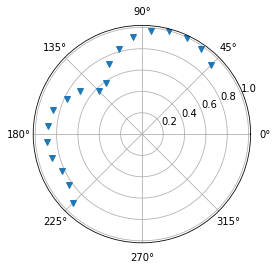

In [54]:
import matplotlib.pyplot as plt
plt.polar(x_rem,y_rem,'v')


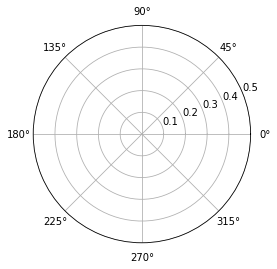

In [55]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_rem, abs(np.array(y_rem)), marker = 'x')
ax.set_rmax(0.5)
ax.set_rmin(0)
plt.show()

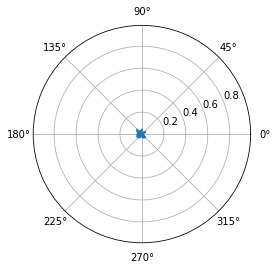

In [56]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
ax.plot(x_rem_eb, abs(np.array(y_rem_eb)), marker = 'x')
ax.set_rmax(0.99)
ax.set_rmin(0)
plt.show()

In [57]:
# experimental data
path='/home/vagner/Desktop/galfenol/galmrtheta.txt'
#path='/home/vagner/Desktop/galfenol/gal90deg.txt'
#path='/home/vagner/Desktop/galfenol/gal50deg.txt'
#path = '/home/vagner/Desktop/galfenol/gal0deg.txt'

hexp10ktube = open(path,'r')
hexp=hexp10ktube.readlines()

print(hexp[0])
#print(a1[0][1])

theta_on=[]
mexp_on=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    theta_on.append(float(listexp[0]))
    mexp_on.append(float(listexp[1].split('\n')[0]))





0	935



In [58]:
mexp_on=np.array(mexp_on)/1050.

In [59]:
theta_on=np.array(theta_on)/180.0*3.1415

In [60]:
mexp_on

array([0.89047619, 0.93761905, 0.98533333, 0.98095238, 0.96914286,
       0.96346667, 0.95428571, 0.81571429, 0.78338095, 0.67871429,
       0.70964762, 0.76548571, 0.79199048, 0.85672381, 0.87092381,
       0.88038095, 0.86684762, 0.8426    , 0.82254286])

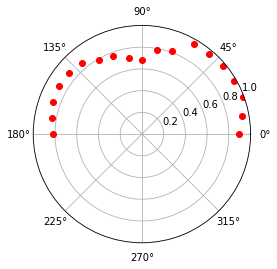

In [61]:
import matplotlib.pyplot as plt
plt.polar(theta_on,mexp_on,'ro')

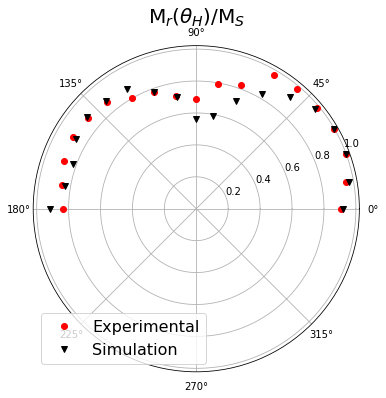

In [104]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
l1=plt.polar(theta_on,mexp_on/max(mexp_on),'ro',color='red',label='Experimental')
#plt.polar(theta_on,mexp_on/1,'ro')
l2=plt.polar(np.array(x_rem)-pi/4.,np.array(y_rem)*1,'ro', marker = 'v',color='black',label='Simulation')
plt.title('M$_r (\\theta_H)$/M$_S$',size=20)
plt.legend(fontsize=16,loc='best')
#plt.ylabel('Mr/M$_S$',rotation=90,size=28)
#plt.savefig('Mr_galfenol_polar.jpg',resolution=300)
plt.show()


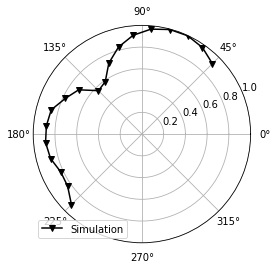

In [63]:
import matplotlib.pyplot as plt

ax = plt.subplot(111, projection='polar')
l1=ax.plot(x_rem, abs(np.array(y_rem)), marker = 'v',color='black',label='Simulation')
#l2=ax.plot(theta_on, mexp_on/1, marker = 'o',color='red',label='Experimental')

#l2=ax.plot(theta_on, mexp_on/max(mexp_on), marker = 'o',color='red',label='Experimental')

ax.legend()
#plt.legend((l1,l2),('90 deg','50 deg'),fontsize=20)

ax.set_rmax(1.0)
ax.set_rmin(0)

# filme
#plt.savefig("polarplot_mr_intermoriyaquadratic")
#plt.savefig("polarplot_mr_interdipolar")
#plt.savefig("polarplot_mr_interexchange")
#plt.savefig("polarplot_mr_intermoriya")
#plt.savefig("polarplot_mr_intermoriyamultichiralspin")
#plt.savefig("polarplot_mr_interexchangebiquad")

# nanomembrane!
#plt.savefig("polarplot_mr_intermoriyamultichiralspin_nmb")
#plt.savefig("polarplot_mr_interdipolar_nmb")
#plt.savefig("polarplot_mr_interdipolar_nmb_longer")


plt.show()

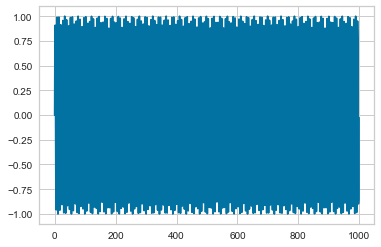

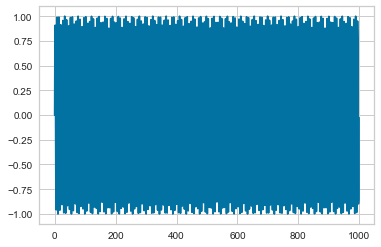

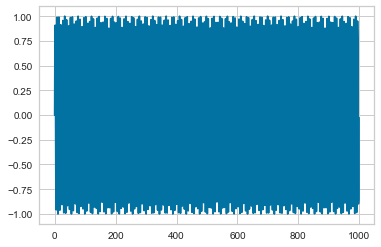

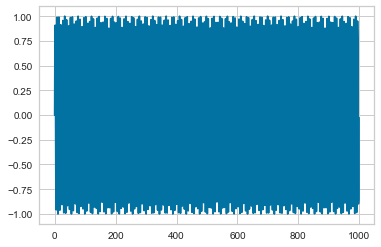

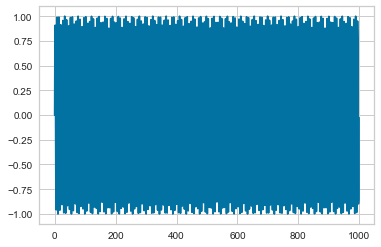

In [433]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(1000)
y = np.sin(x)

for i in range(5):
    %matplotlib inline
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x, y)
    plt.show
    plt.pause(5)
#    plt.close(fig)

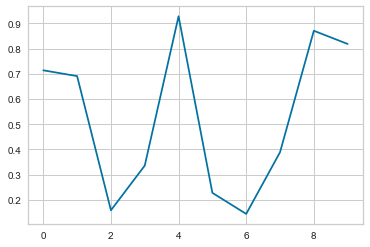

<Figure size 432x288 with 0 Axes>

In [435]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

plt.ion()
for i in range(50):
    clear_output(wait=True)
    y = np.random.random([10,1])
    plt.plot(y)
    plt.draw()
    plt.pause(0.01)
    plt.clf()

In [505]:
m_inter_0,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,0/1*pi/180.)
m_inter_45,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,45/1*pi/180.)
m_inter_90,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,90/1*pi/180.)

In [506]:
m_inter_20,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,20/1*pi/180.)
m_inter_70,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,70/1*pi/180.)


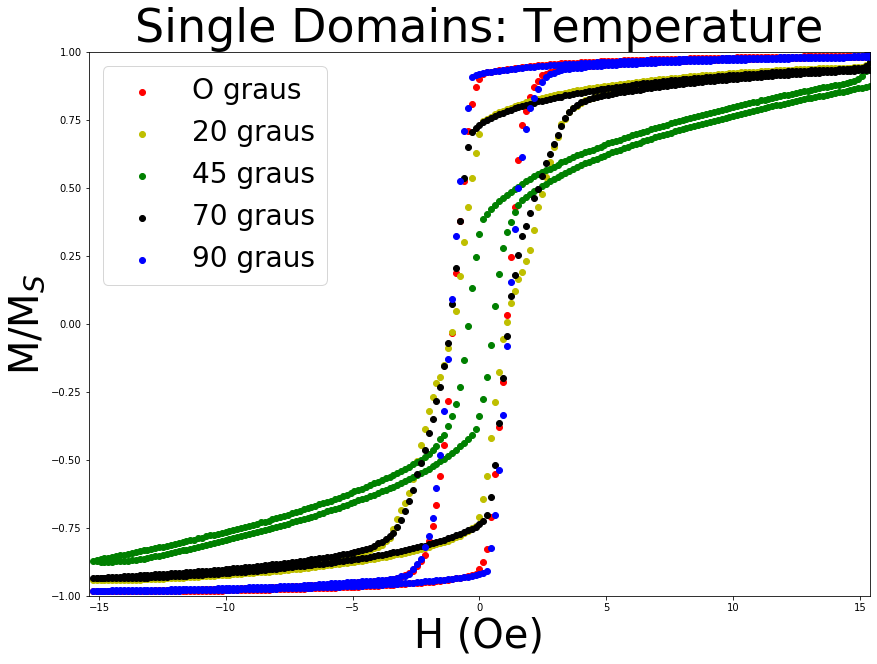

In [507]:
%matplotlib inline
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(14,10))

plt.title("Single Domains: Temperature",size=46)

#plt.scatter(np.array(h_inter)[:int(len(h_inter)*2/2.)],np.array(m_inter)[:int(len(h_inter)*2/2.)]/norm,color='r')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_0))/1./norm,color='r',label='O graus')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_20))/1./norm,color='y',label='20 graus')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_45))/1./norm,color='g',label='45 graus')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_70))/1./norm,color='black',label='70 graus')
plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_90))/1./norm,color='b', label='90 graus')
#plt.scatter(-np.array(h_inter),-np.array(m_inter)/norm,color='b')

plt.legend(fontsize=28)

#plt.scatter(hexp_on,np.array(mexp_on)/0.99)

#plt.xlim(-1600*3*3,1600*3*3)
plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.ylim(-1,1)
plt.xlabel('H (Oe)',size=40)
plt.ylabel('M/M$_S$',size=40)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')
#plt.savefig('singledomains_withtemperature.jpg',resolution=300)
#plt.savefig('singledomains_notemperature.jpg',resolution=300)

#plt.savefig('singledomains_withtemperature_biaxial.jpg',resolution=300)
#plt.savefig('singledomains_notemperature_biaxial.jpg',resolution=300)


plt.show()



In [1119]:
m_inter_0,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,0/1*pi/180.+45/1*pi/180.)


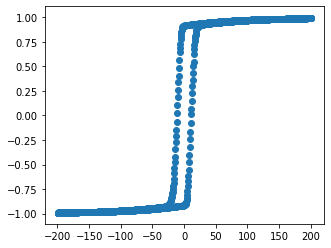

In [1120]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,4])
plt.scatter(h_inter,m_inter_0)
plt.show()

In [1121]:
m_inter_45,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,45/1*pi/180.+45/1*pi/180.)


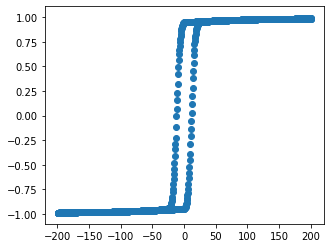

In [1122]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,4])
plt.scatter(h_inter,m_inter_45)
plt.show()

In [1123]:
m_inter_90,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,90/1*pi/180.+45/1*pi/180.)

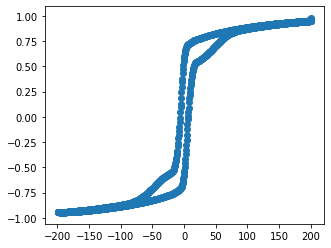

In [1124]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,4])
plt.scatter(h_inter,m_inter_90)
plt.show()

In [1125]:
m_inter_140,h_inter,h_test,hnowlist = hysteresis_inter(NN2,Msat,hpasso,140/1*pi/180.+45/1*pi/180.)

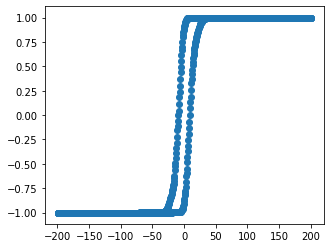

In [1126]:
import matplotlib.pyplot as plt
plt.figure(figsize=[5,4])
plt.scatter(h_inter,m_inter_140)
plt.show()

In [1127]:
# experimental data
path1='/home/vagner/Desktop/galfenol/gal90deg.txt'
path2='/home/vagner/Desktop/galfenol/gal50deg.txt'
path3 = '/home/vagner/Desktop/galfenol/gal0deg.txt'
path4 = 'gal140deg.txt'

hexp10ktube = open(path1,'r')
hexp=hexp10ktube.readlines()


hexp_on1=[]
mexp_on1=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on1.append(float(listexp[0]))
    mexp_on1.append(float(listexp[1].split('\n')[0]))

hexp10ktube = open(path2,'r')
hexp=hexp10ktube.readlines()


hexp_on2=[]
mexp_on2=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on2.append(float(listexp[0]))
    mexp_on2.append(float(listexp[1].split('\n')[0]))
        
    
hexp10ktube = open(path3,'r')
hexp=hexp10ktube.readlines()


hexp_on3=[]
mexp_on3=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on3.append(float(listexp[0]))
    mexp_on3.append(float(listexp[1].split('\n')[0]))

hexp10ktube = open(path4,'r')
hexp=hexp10ktube.readlines()

hexp_on4=[]
mexp_on4=[]
hexp10ktube.close()
for i in range(len(hexp)):
    listexp=hexp[i].split('\t')
    hexp_on4.append(float(listexp[0]))
    mexp_on4.append(float(listexp[1].split('\n')[0]))
            

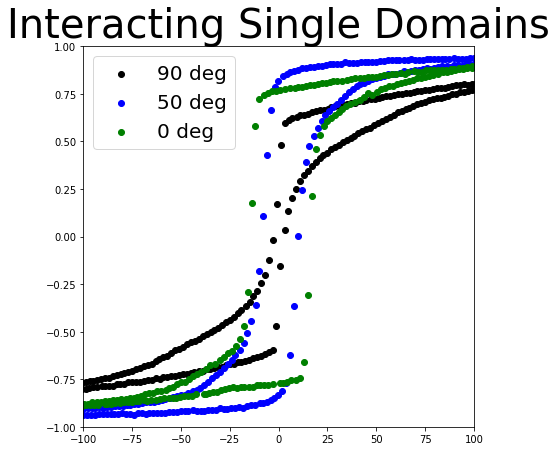

In [1128]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l1=plt.scatter(hexp_on1,np.array(mexp_on1),color='black',label='90 deg')
l2=plt.scatter(hexp_on2,np.array(mexp_on2),color='blue',label='50 deg')
l3=plt.scatter(hexp_on3,np.array(mexp_on3),color='green',label='0 deg')

plt.legend((l1,l2,l3),('90 deg','50 deg','0 deg'),fontsize=20)

#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

plt.show()




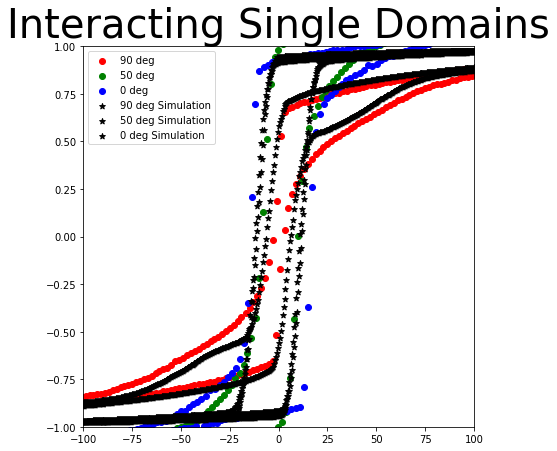

In [1129]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l1=plt.scatter(hexp_on1,np.array(mexp_on1)*1.1,color='r',label='90 deg')
l2=plt.scatter(hexp_on2,np.array(mexp_on2)*1.2,color='g',label='50 deg')
l3=plt.scatter(hexp_on3,np.array(mexp_on3)*1.2,color='b',label='0 deg')

s1=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_0))/1./norm,color='black',label='O graus simulation',marker='*')
s2=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_45))/1./norm,color='black',label='45 graus simulation',marker='*')
s3=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_90))/1./norm,color='black', label='90 graus simulation',marker='*')

plt.legend((l1,l2,l3,s1,s2,s3),('90 deg','50 deg','0 deg','90 deg Simulation','50 deg Simulation','0 deg Simulation'),fontsize=10)

#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

plt.show()




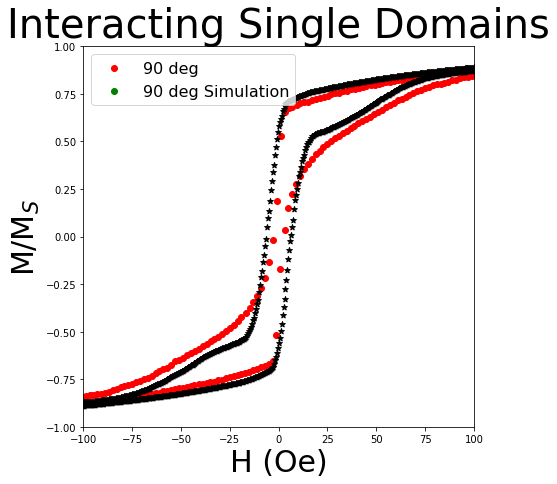

In [1136]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l1=plt.scatter(hexp_on1,np.array(mexp_on1)*1.1,color='r',label='90 deg')

s1=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_90))/1./norm,color='black',label='O graus simulation',marker='*')

plt.legend((l1,l2,l3,s1,s2,s3),('90 deg','90 deg Simulation'),fontsize=16)

plt.xlabel("H (Oe)",size=30)
plt.ylabel("M/M$_S$",size=30)

#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

#plt.savefig('galfenol_90deg.jpg')

plt.show()




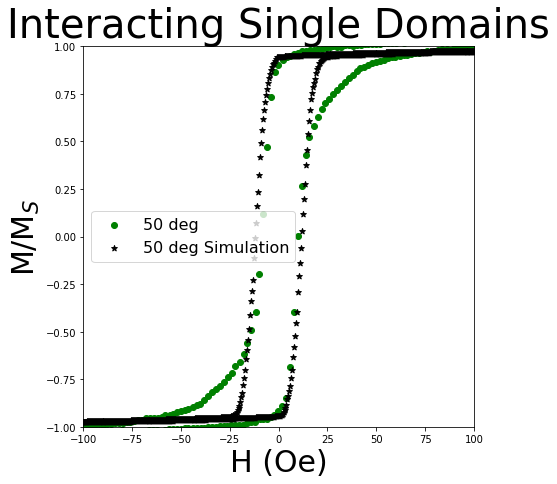

In [1138]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l2=plt.scatter(hexp_on2,np.array(mexp_on2)*1.1,color='g',label='50 deg')

s2=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_45))/1./norm,color='black',label='45 graus simulation',marker='*')

plt.legend((l2,s2),('50 deg','50 deg Simulation'),fontsize=16)

plt.xlabel("H (Oe)",size=30)
plt.ylabel("M/M$_S$",size=30)

#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

#plt.savefig('galfenol_45deg.jpg')

plt.show()




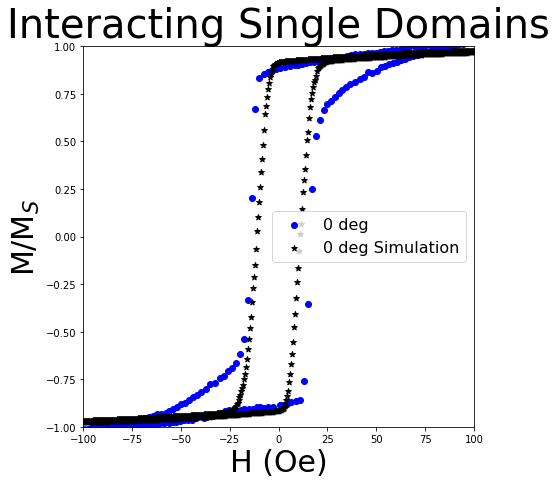

In [1141]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l3=plt.scatter(hexp_on3,np.array(mexp_on3)*1.15,color='b',label='0 deg')

s3=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_0))/1./norm,color='black', label='90 graus simulation',marker='*')

plt.legend((l3,s3),('0 deg','0 deg Simulation'),fontsize=16)

plt.xlabel("H (Oe)",size=30)
plt.ylabel("M/M$_S$",size=30)


#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

#plt.savefig('galfenol_0deg.jpg')


plt.show()




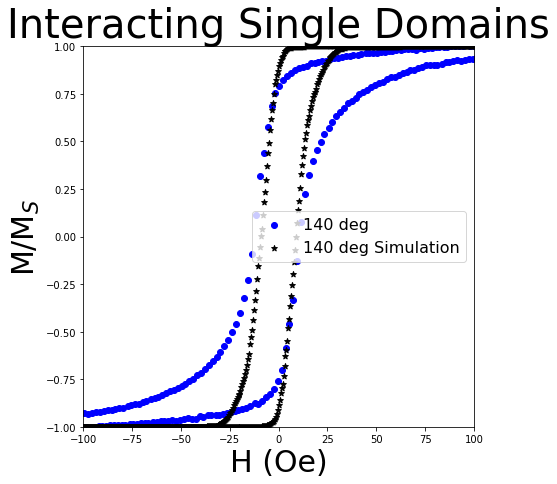

In [1144]:
import matplotlib.pyplot as plt

norm=1.00

plt.figure(figsize=(7,7))

plt.title("Interacting Single Domains",size=40)

l4=plt.scatter(hexp_on4,np.array(mexp_on4)*1.2,color='b',label='0 deg')

s4=plt.scatter(np.array(h_inter),(4/4*np.array(m_inter_140))/1./norm,color='black', label='90 graus simulation',marker='*')

plt.legend((l4,s4),('140 deg','140 deg Simulation'),fontsize=16)

plt.xlabel("H (Oe)",size=30)
plt.ylabel("M/M$_S$",size=30)


#plt.xlim(-1600*3*3,1600*3*3)
#plt.xlim(-abs(hini/1.),abs(hini/1.))
plt.xlim(-100,100)
plt.ylim(-1,1)
#plt.savefig('firstsimul_20x20_interdipol_3D.jpeg')
#plt.savefig('firstsimul_20x20_nointer_3D.jpeg')
##plt.savefig('firstsimul_10x10_nointer.jpeg')
#plt.savefig('firstsimul_12x12_nointer_3D.jpeg')
#plt.savefig('firstsimul_12x12_interdipol_3D.jpeg')

#plt.savefig('galfenol_140deg.jpg')

plt.show()




In [1409]:
Kf2_bi/Kf1_bi

-1.0

In [1411]:
Kf1_gal

2000.0